In [ ]:
# %load cnn_model.py

import tensorflow as tf


class TCNNConfig(object):
    """CNN配置参数"""

    embedding_dim = 64  # 词向量维度
    seq_length = 600  # 序列长度
    num_classes = 10  # 类别数
    num_filters = 256  # 卷积核数目
    kernel_size = 5  # 卷积核尺寸
    vocab_size = 5000  # 词汇表达小

    hidden_dim = 128  # 全连接层神经元

    dropout_keep_prob = 0.5  # dropout保留比例
    learning_rate = 1e-3  # 学习率

    batch_size = 64  # 每批训练大小
    num_epochs = 10  # 总迭代轮次

    print_per_batch = 100  # 每多少轮输出一次结果
    save_per_batch = 10  # 每多少轮存入tensorboard


class TextCNN(object):
    """文本分类，CNN模型"""

    def __init__(self, config):
        self.config = config

        # 三个待输入的数据，都是tensor，没有具体的值
        # 建立了三个占位符，此时并没有输入数据，等建立Session,模型开始运行时再通过feed_dict喂入数据。
        # None是bitch_size,input_x是（64，600）的维度，input_y的维度是（64，10）
        self.input_x = tf.placeholder(tf.int32, [None, self.config.seq_length], name='input_x')
        self.input_y = tf.placeholder(tf.float32, [None, self.config.num_classes], name='input_y')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        self.cnn()

    def cnn(self):
        """CNN模型"""
        # 词向量映射
        # 指定在第1块gpu上运行，如果指定是cpu则（'/cpu:0'）
        
        with tf.device('/gpu:0'):
            #获取已经存在的变量，并随机初始化，并为之命名。embedding的维度是（5000，64）
            embedding = tf.get_variable('embedding', [self.config.vocab_size, self.config.embedding_dim])
            
            #embedding的过程是，首先拿到一个包含64个样本的batch（64，600），然后取其中一个样本（1，600）
            #然后用每一个字对应的索引取到一个64维的向量，于是每个样本就成了（600，64）的矩阵。
            #tf.nn.embedding_lookup（params, ids）是选取一个张量里面索引对应的元素，
            #如第一个样本是[100,2,..],那么从embedding里取第100行（从0开始计行数）作为第0行，一直这样取600次，再结合要取64个样本
            #所以embedding_inputs.shape=(64，600,64)
            #input_x.shape=(64,600)，如果规定了一批取64个样本。
            embedding_inputs = tf.nn.embedding_lookup(embedding, self.input_x)

        with tf.name_scope("cnn"):
            # CNN layer
            # 使用一维卷积核进行卷积，因为卷积核的第二维与词向量维度相同，只能沿着行向下滑动。
            #对于64个样本中的每一个样本，句子长度为600个字，每个字向量的维度为64，有256个过滤器，卷积核的尺寸为5，
            #那么输入样本为(600,64)经过(5,64)的卷积核卷积后得到(596,1)的向量（600-5+1），默认滑动为1步。
            #由于有256个过滤器，于是得到256个(596,1)的向量。
            #结果显示为(None,596,256)
            #embedding_inputs.shape=(64，600,64)
            conv = tf.layers.conv1d(embedding_inputs, self.config.num_filters, self.config.kernel_size, name='conv')
            # global max pooling layer
            # 用最大池化方法，按行求最大值，conv.shape=[Dimension(None), Dimension(596), Dimension(256)],留下了第1和第3维。
            #取每个向量(596,1)中的最大值，然后就得到了256个最大值，
            #gmp.shape=[Dimension(None), Dimension(256)
            gmp = tf.reduce_max(conv, reduction_indices=[1], name='gmp')

        with tf.name_scope("score"):
            # 全连接层，后面接dropout以及relu激活
            # 神经元的个数为128个，gmp为(64,256),经过这一层得到fc的维度是(64，128）
            fc = tf.layers.dense(gmp, self.config.hidden_dim, name='fc1')
            #tf.contrib.layers是比tf.layers封装得更高级的库，这里是进行dropout，
            fc = tf.contrib.layers.dropout(fc, self.keep_prob)
            #运用RELU激活函数，tf.nn是比tf.layers更底层的库。
            fc = tf.nn.relu(fc)

            # 分类器
            #self.logits的维度是[Dimension(None), Dimension(10)],应该是（64，10）
            self.logits = tf.layers.dense(fc, self.config.num_classes, name='fc2')
            #softmax得到的输出为[Dimension(None), Dimension(10)],是10个类别的概率
            # 然后再从中选出最大的那个值的下标，如[9,1,3...]
            # 最后得到的是（64，1）的列向量，即64个样本对应的类别。
            self.y_pred_cls = tf.argmax(tf.nn.softmax(self.logits), 1)  # 预测类别

        with tf.name_scope("optimize"):
            # 损失函数，交叉熵，self.logits是全连接层的输出，（64，10），而labels是（64，10）的ont-hot
            # 这个函数先对self.logits进行softmax运算求概率分布，然后再求交叉熵损失
            # 得到的结果维度是（64，1），元素即每个样本对应的交叉熵。
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, labels=self.input_y)
            # tf.reduce_mean(input_tensor,axis)用于求平均值，这里是求64个样本的交叉熵损失的均值。
            self.loss = tf.reduce_mean(cross_entropy)
            # 优化器使用自适应学习率算法。
            self.optim = tf.train.AdamOptimizer(learning_rate=self.config.learning_rate).minimize(self.loss)

        with tf.name_scope("accuracy"):
            # 准确率的计算，tf.equal对内部两个向量的每个元素进行对比，返回[True,False,True,...]这样的向量
            # 也就是对预测类别和标签进行对比，self.y_pred_cls形如[9,0,2,3,...]
            correct_pred = tf.equal(tf.argmax(self.input_y, 1), self.y_pred_cls)
            # tf.cast函数将布尔类型转化为浮点型，True转为1.，False转化为0.，返回[1,0,1,...]
            # 然后对[1,0,1,...]这样的向量求均值，恰好就是1的个数除以所有的样本，恰好是准确率。
            self.acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [ ]:
# %load predict.py

from __future__ import print_function

import os
import tensorflow as tf
import tensorflow.contrib.keras as kr

from cnn_model import TCNNConfig, TextCNN
from data.cnews_loader import read_category, read_vocab

try:
    bool(type(unicode))
except NameError:
    unicode = str

base_dir = 'data/cnews'
vocab_dir = os.path.join(base_dir, 'cnews.vocab.txt')

save_dir = 'checkpoints/textcnn'
save_path = os.path.join(save_dir, 'best_validation')  # 最佳验证结果保存路径


class CnnModel:
    def __init__(self):
        self.config = TCNNConfig()
        self.categories, self.cat_to_id = read_category()
        self.words, self.word_to_id = read_vocab(vocab_dir)
        self.config.vocab_size = len(self.words)
        self.model = TextCNN(self.config)

        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(sess=self.session, save_path=save_path)  # 读取保存的模型

    def predict(self, message):
        # 支持不论在python2还是python3下训练的模型都可以在2或者3的环境下运行
        content = unicode(message)
        data = [self.word_to_id[x] for x in content if x in self.word_to_id]

        feed_dict = {
            self.model.input_x: kr.preprocessing.sequence.pad_sequences([data], self.config.seq_length),
            self.model.keep_prob: 1.0
        }

        y_pred_cls = self.session.run(self.model.y_pred_cls, feed_dict=feed_dict)
        return self.categories[y_pred_cls[0]]


if __name__ == '__main__':
    cnn_model = CnnModel()
    test_demo = ['三星ST550以全新的拍摄方式超越了以往任何一款数码相机',
                 '热火vs骑士前瞻：皇帝回乡二番战 东部次席唾手可得新浪体育讯北京时间3月30日7:00']
    for i in test_demo:
        print(cnn_model.predict(i))


In [ ]:
# %load run_cnn.py
#!/usr/bin/python

from __future__ import print_function

import os
import sys
import time
from datetime import timedelta

import numpy as np
import tensorflow as tf
from sklearn import metrics

from cnn_model import TCNNConfig, TextCNN
from data.cnews_loader import read_vocab, read_category, batch_iter, process_file, build_vocab

base_dir = 'data/cnews'
train_dir = os.path.join(base_dir, 'cnews.train.txt')
test_dir = os.path.join(base_dir, 'cnews.test.txt')
val_dir = os.path.join(base_dir, 'cnews.val.txt')
vocab_dir = os.path.join(base_dir, 'cnews.vocab.txt')
#模型保存的目录，必须至少有一层文件夹，这里有两层
save_dir = 'checkpoints/textcnn'
#这里说是保存路径，其实这个“best_validation”是保存的文件的名字的开头，比如保存的一个文件是“best_validation.index”
save_path = os.path.join(save_dir, 'best_validation')  # 最佳验证结果保存路径


def get_time_dif(start_time):
    """获取已使用时间"""
    end_time = time.time()
    time_dif = end_time - start_time
    #round函数是对浮点数四舍五入为int，注意版本3中round(0.5)=0,round(3.567,2)=3.57。
    #timedelta是用于对间隔进行规范化输出，间隔10秒的输出为：00:00:10
    
    return timedelta(seconds=int(round(time_dif)))


def feed_data(x_batch, y_batch, keep_prob):
    feed_dict = {
        model.input_x: x_batch,
        model.input_y: y_batch,
        model.keep_prob: keep_prob
    }
    return feed_dict


def evaluate(sess, x_, y_):
    """评估在某一数据上的准确率和损失"""
    data_len = len(x_) #test_data有10000个样本
    # 生成一个迭代器，每次循环都会得到两个矩阵，分别是x_batch和y_batch。
    batch_eval = batch_iter(x_, y_, 128)
    total_loss = 0.0
    total_acc = 0.0
    for x_batch, y_batch in batch_eval:
        batch_len = len(x_batch) #128，这里一个批量是取128个样本
        
        #1.0是dropout值，在测试时不需要舍弃，feed_dict得到一个字典，包含x,y和keep_drop值。
        feed_dict = feed_data(x_batch, y_batch, 1.0)
        #把feed_dict的数据传入去计算model.loss,是求出了128个样本的平均交叉熵损失
        loss, acc = sess.run([model.loss, model.acc], feed_dict=feed_dict)
        # 把平均交叉熵和平均准确率分别乘以128个样本得到总数，在不断累加得到10000个样本的总数。
        total_loss += loss * batch_len
        total_acc += acc * batch_len
    # 求出10000个样本的平均交叉熵，和平均准确率。
    return total_loss / data_len, total_acc / data_len


def train():
    print("Configuring TensorBoard and Saver...")
    # 配置 Tensorboard，重新训练时，请将tensorboard文件夹删除，不然图会覆盖
    tensorboard_dir = 'tensorboard/textcnn'
    if not os.path.exists(tensorboard_dir):
        os.makedirs(tensorboard_dir)

    tf.summary.scalar("loss", model.loss)
    tf.summary.scalar("accuracy", model.acc)
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(tensorboard_dir)

    # 配置 Saver
    saver = tf.train.Saver()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Loading training and validation data...")
    # 载入训练集与验证集
    start_time = time.time()
    x_train, y_train = process_file(train_dir, word_to_id, cat_to_id, config.seq_length)
    x_val, y_val = process_file(val_dir, word_to_id, cat_to_id, config.seq_length)
    
    #获取准备数据所花费的时间
    time_dif = get_time_dif(start_time)
    print("Time usage:", time_dif)

    # 创建session
    session = tf.Session()
    # tf.global_variables_initializer()添加节点用于初始化所有的变量，为必备语句
    session.run(tf.global_variables_initializer())
    # 和writer = tf.summary.Filewriter()搭配食用生成神经网络数据流程图，为必备语句

    writer.add_graph(session.graph)

    print('Training and evaluating...')
    start_time = time.time()
    total_batch = 0  # 总批次
    best_acc_val = 0.0  # 最佳验证集准确率
    last_improved = 0  # 记录上一次提升批次
    require_improvement = 1000  # 如果超过1000轮未提升，提前结束训练

    flag = False
    # epoch=10,训练10轮
    for epoch in range(config.num_epochs):
        print('Epoch:', epoch + 1)
        #batch_train是一个能返回两个矩阵的迭代器
        batch_train = batch_iter(x_train, y_train, config.batch_size)
        
        # x_batch.shape为(64,600)
        for x_batch, y_batch in batch_train:
            #构造一个字典，以满足神经网络的输入需要
            feed_dict = feed_data(x_batch, y_batch, config.dropout_keep_prob)
            #print("x_batch is {}".format(x_batch.shape))
            # total_batch初始值为0，save.per_batch=10
            if total_batch % config.save_per_batch == 0:
                # 每多少轮次将训练结果写入tensorboard scalar
                #下面这个语句是难点，后续要继续研究。
                s = session.run(merged_summary, feed_dict=feed_dict)
                writer.add_summary(s, total_batch)

            if total_batch % config.print_per_batch == 0:
                # 每多少轮次输出在训练集和验证集上的性能
                feed_dict[model.keep_prob] = 1.0
                loss_train, acc_train = session.run([model.loss, model.acc], feed_dict=feed_dict)
                loss_val, acc_val = evaluate(session, x_val, y_val)  # todo

                if acc_val > best_acc_val:
                    # 保存最好结果
                    best_acc_val = acc_val
                    last_improved = total_batch
                    saver.save(sess=session, save_path=save_path)
                    improved_str = '*'
                else:
                    improved_str = ''

                time_dif = get_time_dif(start_time)
                msg = 'Iter: {0:>6}, Train Loss: {1:>6.2}, Train Acc: {2:>7.2%},' \
                      + ' Val Loss: {3:>6.2}, Val Acc: {4:>7.2%}, Time: {5} {6}'
                print(msg.format(total_batch, loss_train, acc_train, loss_val, acc_val, time_dif, improved_str))

            session.run(model.optim, feed_dict=feed_dict)  # 运行优化
            total_batch += 1

            if total_batch - last_improved > require_improvement:
                # 验证集正确率长期不提升，提前结束训练
                print("No optimization for a long time, auto-stopping...")
                flag = True
                break  # 跳出循环
        if flag:  # 同上
            break


def test():
    print("Loading test data...")
    start_time = time.time()
    # 下面两个的维度分别为(10000,600),(10000,10)
    x_test, y_test = process_file(test_dir, word_to_id, cat_to_id, config.seq_length)
    
    
    # saver的操作必须在sess建立后进行。
    session = tf.Session()
    # 这里为啥要初始化呢，可能是前面定义了变量，比如用tf.placeholder,后面再看看。
    session.run(tf.global_variables_initializer())
    # 在保存和恢复模型时都需要首先运行这一行：tf.train.Saver()，而不是只有保存时需要。
    saver = tf.train.Saver()
    saver.restore(sess=session, save_path=save_path)  # 读取保存的模型

    print('Testing...')
    # 返回了10000个总测试样本的平均交叉熵损失和平均准率。
    loss_test, acc_test = evaluate(session, x_test, y_test)
    
    # 格式化输出，6表示分配6个占位符，>表示对传入的值右对齐，2表示保留2位小数。
    msg = 'Test Loss: {0:>6.2}, Test Acc: {1:>7.2%}'
    print(msg.format(loss_test, acc_test))

    batch_size = 128
    data_len = len(x_test) #为10000
    num_batch = int((data_len - 1) / batch_size) + 1 #为79，也就是1轮下来要取79个批量
    # 得到[0,0,..,6,6,6,...,9,9,9]这样的向量，也就是每个样本的标签转化为对应的数字索引。
    y_test_cls = np.argmax(y_test, 1)
    #生成一个(10000,)的数组，用来保存预测值。
    y_pred_cls = np.zeros(shape=len(x_test), dtype=np.int32)  # 保存预测结果
    for i in range(num_batch):  # 逐批次处理
        start_id = i * batch_size
        # i=0时，取[0,1*128),i=77时，取[77*128,78*128),i=78时，取[78*128,10000),因为79*128=10112>10000.
        end_id = min((i + 1) * batch_size, data_len)
        feed_dict = {
            model.input_x: x_test[start_id:end_id],
            model.keep_prob: 1.0 #测试的时候不需要dropout神经元。
        }
        #等号右边得到是（128，）的数组，即每个样本的类别，[0,0,...,6,6,6,..]这样的。
        # y_pred_cls仍然是（10000，）的数组。
        y_pred_cls[start_id:end_id] = session.run(model.y_pred_cls, feed_dict=feed_dict)

    # 评估
    print("Precision, Recall and F1-Score...")
    # 可以得到准确率 、找回率和F1_score
    print(metrics.classification_report(y_test_cls, y_pred_cls, target_names=categories))

    # 混淆矩阵
    print("Confusion Matrix...")
    cm = metrics.confusion_matrix(y_test_cls, y_pred_cls)
    print(cm)

    time_dif = get_time_dif(start_time)
    print("Time usage:", time_dif)


if __name__ == '__main__':
    
    config = TCNNConfig()
    if not os.path.exists(vocab_dir):  # 如果不存在词汇表，重建
        build_vocab(train_dir, vocab_dir, config.vocab_size)
    categories, cat_to_id = read_category()
    words, word_to_id = read_vocab(vocab_dir)
    config.vocab_size = len(words)
    model = TextCNN(config)
    option='test'
    if option == 'train':
        train()
    else:
        test()


In [ ]:
# %load cnews_loader.py

import sys
from collections import Counter

import numpy as np
import tensorflow.contrib.keras as kr

if sys.version_info[0] > 2:
    is_py3 = True
else:
    reload(sys)
    sys.setdefaultencoding("utf-8")
    is_py3 = False


def native_word(word, encoding='utf-8'):
    """如果在python2下面使用python3训练的模型，可考虑调用此函数转化一下字符编码"""
    if not is_py3:
        return word.encode(encoding)
    else:
        return word


def native_content(content):
    if not is_py3:
        return content.decode('utf-8')
    else:
        return content


def open_file(filename, mode='r'):
    """
    常用文件操作，可在python2和python3间切换.
    mode: 'r' or 'w' for read or write
    """
    if is_py3:
        return open(filename, mode, encoding='utf-8', errors='ignore')
    else:
        return open(filename, mode)


def read_file(filename):
    """读取文件数据"""
    contents, labels = [], []
    with open_file(filename) as f:
        for line in f:
            try:
                label, content = line.strip().split('\t')
                if content:
                    contents.append(list(native_content(content)))
                    labels.append(native_content(label))
            except:
                pass
    return contents, labels


def build_vocab(train_dir, vocab_dir, vocab_size=5000):
    """根据训练集构建词汇表，存储"""
    data_train, _ = read_file(train_dir)

    all_data = []
    for content in data_train:
        all_data.extend(content)

    counter = Counter(all_data)
    count_pairs = counter.most_common(vocab_size - 1)
    words, _ = list(zip(*count_pairs))
    # 添加一个 <PAD> 来将所有文本pad为同一长度
    words = ['<PAD>'] + list(words)
    open_file(vocab_dir, mode='w').write('\n'.join(words) + '\n')


def read_vocab(vocab_dir):
    """读取词汇表"""
    # words = open_file(vocab_dir).read().strip().split('\n')
    with open_file(vocab_dir) as fp:
        # 如果是py2 则每个值都转化为unicode
        words = [native_content(_.strip()) for _ in fp.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id


def read_category():
    """读取分类目录，固定"""
    categories = ['体育', '财经', '房产', '家居', '教育', '科技', '时尚', '时政', '游戏', '娱乐']

    categories = [native_content(x) for x in categories]

    cat_to_id = dict(zip(categories, range(len(categories))))

    return categories, cat_to_id


def to_words(content, words):
    """将id表示的内容转换为文字"""
    return ''.join(words[x] for x in content)


def process_file(filename, word_to_id, cat_to_id, max_length=600):
    """将文件转换为id表示"""
    contents, labels = read_file(filename)

    data_id, label_id = [], []
    for i in range(len(contents)):
        data_id.append([word_to_id[x] for x in contents[i] if x in word_to_id])
        label_id.append(cat_to_id[labels[i]])

    # 使用keras提供的pad_sequences来将文本pad为固定长度
    x_pad = kr.preprocessing.sequence.pad_sequences(data_id, max_length)
    y_pad = kr.utils.to_categorical(label_id, num_classes=len(cat_to_id))  # 将标签转换为one-hot表示

    return x_pad, y_pad


def batch_iter(x, y, batch_size=64):
    """生成批次数据"""
    #长度为50000
    data_len = len(x)
    #int()可以将其他类型转化为整型，也可以用于向下取整，这里为782.
    num_batch = int((data_len - 1) / batch_size) + 1
    #元素的范围是0-49999，形如[256,189,2,...]的拥有50000个元素的列表
    indices = np.random.permutation(np.arange(data_len))
    # 用indices对样本和标签按照行进行重新洗牌，接着上面的例子，把第256行(从0开始计)放在第0行，第189行放在第1行.
    x_shuffle = x[indices]
    y_shuffle = y[indices]

    for i in range(num_batch):
        start_id = i * batch_size
        #i=780时，end_id=781*64=49984;
        #当i=781时，end_id=50000，因为782*64=50048>50000,所以最后一批取[49984:50000]
        end_id = min((i + 1) * batch_size, data_len)
        # yield是生成一个迭代器，用for循环来不断生成下一个批量。
        # 为了防止内存溢出，每次只取64个，内存占用少。
        yield x_shuffle[start_id:end_id], y_shuffle[start_id:end_id]


# 1 python知识：理解 if not x

1 使用if not x这种写法的前提是：必须清楚x等于None,  False, 空字符串"", 0, 空列表[], 空字典{}, 空元组()时对你的判断没有影响才行。

2 使用if not x 的意思是：x的值可以是布尔类型（True,False) 、字符串、列表、字典等类型，以布尔类型为例，if not x 等价于if x is False。

因此x = False 时会执行下面的代码，这与常识相反，因为会把if not False 误认为等价于if True，而x的值是False,因此不执行。 

In [9]:
# if not x 的例子
x = []
if not x: 
    x.append([1,2])
else:
    x.append([3,4])
print(x)

if not x:
    x.append([1,2])
else:
    x.append([3,4])
print(x)

[[1, 2]]
[[1, 2], [3, 4]]


# 2 python知识：用sys获取python的版本

[参考资料](https://www.jianshu.com/p/bf0e34367ac6)

In [17]:
import sys
sys.version_info

sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

In [18]:
#得到版本为3
sys.version_info[0]

3

# 3 python知识：版本2中的reload（sys）

[参考资料](https://blog.csdn.net/qq_36711420/article/details/79382327)

python2在安装时，默认的编码是ascii，当程序中出现非ascii编码时，python2的处理常常会报错,python3不存在这个问题。

运行如下代码进行“utf-8”编码：

    import sys
    reload(sys)
    sys.setdefaultencoding("utf-8")

# 4 python知识：readline() 和 readlines()的区别
[参考资料](https://www.cnblogs.com/xiugeng/p/8635862.html)

1. readline():
readline()方法每次读取一行；返回的是该行，是一个字符串对象，保持当前行的内存。下次再次执行时再读取和返回下一行。

2. readlines():
readlines()方法读取所有行然后把它们作为一个字符串列表返回。

In [22]:
#用readline()每次读取一行
file = open('/home/dyy/兼职模特的联系方式.txt', 'r')

while True:
    a = file.readline()
    if a:
        print(type(a),a)
    else:
        break

<class 'str'> 吴迪 177 70 13888888

<class 'str'> 王思 170 50 13988888

<class 'str'> 白雪 167 48 13324434

<class 'str'> 黄蓉 166 46 13828382



In [26]:
# 用readlines()读取所有行然后把它们作为一个字符串列表返回。
file = open('/home/dyy/兼职模特的联系方式.txt', 'r')
a = file.readlines()
print(type(a),a,"\n")
for line in a:
    print(type(line),line)
file.close()

<class 'list'> ['吴迪 177 70 13888888\n', '王思 170 50 13988888\n', '白雪 167 48 13324434\n', '黄蓉 166 46 13828382\n'] 

<class 'str'> 吴迪 177 70 13888888

<class 'str'> 王思 170 50 13988888

<class 'str'> 白雪 167 48 13324434

<class 'str'> 黄蓉 166 46 13828382



# 5 tensorflow中的tf.summary操作

[参考资料](https://www.cnblogs.com/mtcnn/p/9411703.html)

1. tf中 tensorboard 工具通过读取在网络训练过程中保存到本地的日志文件实现数据可视化，日志数据保存主要用到 tf.summary 中的方法。 

2. tf.summary提供了像tf.summary.scalar、tf.summary.histogram 等方法，用来把graph图中的相关信息，如结构图、学习率、准确率、Loss等数据转换成 protocol buffer 数据格式，然后再调用 tf.summary.FileWriter 方法把这些数据写入到本地硬盘，之后就可以借用 tensorboard 工具可视化这些数据。


* **标量数据汇总和记录**: tf.summary.scalar


    保存标量，一般用来保存loss，accuary，学习率等数据。

    tf.summary.scalar(name, tensor)
    name:  给保存的数据的命名;
    tensor: 要保存的tensor，在scalar函数中应该是一个标量，如当前的学习率、Loss等;
    
    如：
         
      tf.summary.scalar("acc",model.acc)
      
    
* **变量直方图汇总记录**: tf.summary.histogram  

    输出带直方图的汇总的protobuf 数据。

    tf.summary.histogram(tag, values, collections=None, name=None） 
    
* **合并汇总**: tf.summary.merge_all  

    使用 tf.summary.merge(inputs, collections=None, name=None) 对指定的汇总进行合并。
    
    使用 tf.summaries.merge_all() 对所有的汇总进行合并
    
    
* **数据写入本地磁盘**: tf.summary.FileWriter

    数据写入本地使用 tf.summary.FileWriter 类中的方法。

    summary_writer = tf.summary.FileWriter(args.log_dir, sess.graph)
    
    args.log_dir为tensorboard的目录路径。

# 6 Keras的pad_sequences方法

[参考资料](https://blog.csdn.net/TH_NUM/article/details/80904900)

**语法**：tf.contrib.keras.preprocessing.sequence.pad_sequences 

**作用**：将标量数据转换成 numpy ndarray

**详细分析**：

* **1 语法：**

    keras.preprocessing.sequence.pad_sequences(sequences, maxlen=None, dtype=’int32’, padding=’pre’, truncating=’pre’, 
    value=0.) 
    

* **2 函数说明：**

    将长为nb_samples的序列（标量序列）转化为形如(nb_samples,nb_timesteps)2D numpy array。如果提供了参数maxlen,  
    nb_timesteps=maxlen，否则其值为最长序列的长度。padding和截断发生的位置分别取决于padding和truncating. 
    
    
* **3 参数说明：**

    sequences：浮点数或整数构成的两层嵌套列表

    maxlen：None或整数，为序列的最大长度。大于此长度的序列将被截短，小于此长度的序列将在后部填0.

    dtype：返回的numpy array的数据类型

    padding：‘pre’或‘post’，确定当需要补0时，在序列的起始还是结尾补

    truncating：‘pre’或‘post’，确定当需要截断序列时，从起始还是结尾截断

    value：浮点数，此值将在填充时代替默认的填充值0

In [54]:

import tensorflow as tf
import tensorflow.contrib.keras as kr
import numpy as np

#注意方法为pad_sequnences,是复数要加上“s”
pad_sequence = kr.preprocessing.sequence.pad_sequences
a = [[1,3,5,7,9],[2,4,6,3]]
b_pad = pad_sequence([[1,3,5,7,9],[2,4,6,3]],maxlen=8,dtype="float32",padding='post')
print(b_pad)

[[1. 3. 5. 7. 9. 0. 0. 0.]
 [2. 4. 6. 3. 0. 0. 0. 0.]]


In [41]:
print(b_pad.shape)

(2, 8)


In [55]:
b_pad.dtype

dtype('float32')

# 7 keras.utils.to_categorical方法

[参考资料](https://blog.csdn.net/gdl3463315/article/details/82659378)

**1 语法**：

keras.utils.to_categorical(y, num_classes=None, dtype='float32')

将整型标签y转为onehot,y为int数组，num_classes为标签类别总数。

**2 举例**：

比如有50000条新闻，分为10类，用0-9表示，那么全部样本的标签为50000维的整形数组，进行ont-hot编码时，num_classes=10=max(y)+1,y就成

了(50000,10)维度的二元矩阵。第一条新闻的标签为3，则对应的ont-hot为[0,0,0,1,0,0,0,0,0,0],即除了列表第4个元素为1，其他都为0.


In [56]:
import keras 

ohl=keras.utils.to_categorical([1,3,9]) 
print(ohl) 

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Using TensorFlow backend.


In [57]:
print(ohl.shape)

(3, 10)


In [58]:
print([1,3,9])

[1, 3, 9]


# 8 python知识：time.time()和time.clock()

[参考资料](https://blog.csdn.net/wonengguwozai/article/details/80680699)


**1 cpu 的运行机制：**:

cpu是多任务的，例如在多进程的执行过程中，一段时间内会有对各进程的处理。一个进程从开始到结束其实是在这期间的一些列时间片断上断断续续执行的。所以这就引出了程序执行的cpu时间（该程序单纯在cpu上运行所需时间）和墙上时钟wall time。


**2 time.time()：**

是统计的wall time(即墙上时钟)，也就是系统时钟的时间戳（1970纪元后经过的浮点秒数）。所以两次调用的时间差即为系统经过的总时间。


**3 time.clock()：**

是统计cpu时间的工具，这在统计某一程序或函数的执行速度最为合适。两次调用time.clock()函数的差值即为程序运行的cpu时间。


In [10]:
import time

def proceduce():
    a = 0
    for i in range(100000000):
        a += 1
t0 = time.clock()
t_0 = time.time()

proceduce()

time.sleep(5)

t1 = time.clock()
t_1 = time.time()

print("CPU time is %f"%(t1-t0))
print("Wall time is %0.10f"%(t_1-t_0))
print("Start time is %f"%t_0)


CPU time is 4.502765
Wall time is 9.5133748055
Start time is 1551005531.877501


In [13]:
from datetime import timedelta
print(timedelta(seconds=int(round(t_1-t_0))))

0:00:10


# 9 python知识：datetime.timedelta()

[参考资料](https://blog.csdn.net/sunjinjuan/article/details/79113120)

**1 语法：**

    from datetime import timedelta
    timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
    
**2 用法：**

    datetime.timedelta对象代表两个时间之间的时间差，两个date或datetime对象相减就可以返回一个timedelta对象。

In [25]:
#打印6小时后的时间
import datetime
from datetime import timedelta
now = datetime.datetime.now()
print(now,"\n")

delta = timedelta(hours = 6)
print(delta,"\n")

new_date = now+delta
print(new_date)

2019-02-24 19:32:36.844994 

6:00:00 

2019-02-25 01:32:36.844994


 # 10_tensorflow知识：tf.Session()
 
 Session 是 Tensorflow 为了控制,和输出文件执行结果的语句。运行 session.run() 可以获得你要得知的运算结果, 或者是你所要运算的部分。

In [27]:
import tensorflow as tf

#传入的列表外面还嵌套着一个[]，这个要注意。
matrix1 = tf.constant([[3,3]])
matrix2 = tf.constant([[2],[2]])
product = tf.matmul(matrix1,matrix2)

#product 不是直接计算的步骤, 所以我们会要使用 Session 来激活 product 并得到计算结果. 有两种形式使用会话控制 Session 。

#方法一
sess = tf.Session()
result = sess.run(product)
print(result)
#方法一最后要关闭会话。
sess.close()

[[12]]


In [28]:
#方法二
with tf.Session() as sess:
    result = sess.run(product)
    print(result)

[[12]]


## 10-1 Session.run()方法

Session对象创建完毕，便可以使用它最重要的方法run()来启动所需要的数据流图进行计算。

run()方法有4个参数，run(fetches,feed_dict=Noneoptions=None,run_metadata=None)

In [29]:
#理解一下feed_dict参数的作用

import tensorflow as tf

a = tf.add(1,2)
b = tf.multiply(a,2)

with tf.Session() as sess:
    # 到这里才开始执行a 和 b
    v1 = sess.run(b)
    print(v1)
    # 把30赋值给a
    replace_dict = {a:30}
    # 由replace_dict 得到a=30,然后再把a传入到b的运算中。
    v2 = sess.run(b,feed_dict=replace_dict)
    print(v2)   

6
60


## 10-2 sess.run(tf.global_variables_initializer())

tf.global_variables_initializer()添加节点用于初始化所有的变量(GraphKeys.VARIABLES)。返回一个初始化所有全局变量的操作（Op）。在你构建完整个模型并在会话中加载模型后，运行这个节点。

能够将所有的变量一步到位的初始化，非常的方便。通过feed_dict, 你也可以将指定的列表传递给它，只初始化列表中的变量。

其实上面这几句话我也不懂，博客里抄的，以后慢慢懂吧。

## 10-3 tf.placeholder() 的作用
[参考资料](https://blog.csdn.net/kdongyi/article/details/82343712)

* **【1.语法：】**

    tf.placeholder(dtype, shape=None, name=None)

    此函数用于定义过程，在执行的时候再赋具体的值
    
    **参数：**

    dtype：数据类型。常用的是tf.float32,tf.int32等数值类型
    
    shape：数据形状。默认是None，就是一维值，也可以多维，比如：[None，3]，表示列是3，行不一定
    
    name：名称。

    **返回：**

    Tensor类型
    
    
* **【2.说明：】**

    此函数用于定义过程，在执行的时候再赋具体的值。

    赋值一般用sess.run(feed_dict = {x:xs, y_:ys})，其中x,y_是用placeholder创建出来的。
    
    placeholder()函数是在神经网络构建graph的时候在模型中的占位，此时并没有把要输入的数据传入模型，它只会分配必要的内存。等建立
    
    session，在会话中，运行模型的时候通过feed_dict()函数向占位符喂入数据。
    
    比如每次可以将一个minibatch传入到x = tf.placeholder(tf.float32,[None,32])上，下一次传入的x都替换掉上一次传入的x，这样就对于所
    
    有传入的minibatch x就只会产生一个op，不会产生其他多余的op，进而减少了graph的开销。

In [3]:
import tensorflow as tf
import numpy as np

x = tf.placeholder(tf.float32,shape=(1024,1024))
y = tf.placeholder(tf.float32,shape=(1024,64))
z  =tf.matmul(x,y)

In [4]:
with tf.Session() as sess:
    #np.random.rand()生成服从0-1分布的随机数，元素在[0,1)区间
    rand_x = np.random.rand(1024,1024)
    rand_y = np.random.rand(1024,64)
    result = sess.run(z,feed_dict={x:rand_x,y:rand_y})
    print(result)

[[266.03058 263.92462 262.6416  ... 256.78027 262.14432 271.13297]
 [255.69305 261.6489  261.0907  ... 253.08116 256.0206  261.22986]
 [259.5915  265.2597  264.3842  ... 257.7503  259.45013 262.79504]
 ...
 [263.10913 256.68213 263.5235  ... 248.67197 255.27106 265.40872]
 [252.88419 254.7623  257.09964 ... 245.10152 251.08736 259.20297]
 [262.2569  263.21838 268.1416  ... 253.87949 263.8031  265.7484 ]]


# 11 python知识：np.random.permutation()

[参考资料](https://blog.csdn.net/lyy14011305/article/details/76207327)

**huffle与permutation的区别**

函数shuffle与permutation都是对原来的数组进行重新洗牌（即随机打乱原来的元素顺序）。

区别在于shuffle直接在原来的数组上进行操作，改变原来数组的顺序，无返回值。

permutation不直接在原来的数组上进行操作，而是返回一个新的打乱顺序的数组，并不改变原来的数组。

In [30]:
import numpy as np
a = np.arange(9)
b = np.arange(9).reshape((3,3))
print(a,'\n')
print(b)

[0 1 2 3 4 5 6 7 8] 

[[0 1 2]
 [3 4 5]
 [6 7 8]]


In [35]:
#用permutation()来随机打算元素顺序
a_p = np.random.permutation(a)
b_p = np.random.permutation(b)
print("随机打乱a的顺序：",a_p)
print("随机打乱b的顺序：")
print(b_p,'\n')
print("a 和 b 并没有发生变化：")
print('a:',a,'\n')
print('b:',b)

随机打乱a的顺序： [1 8 2 5 3 6 4 7 0]
随机打乱b的顺序：
[[6 7 8]
 [3 4 5]
 [0 1 2]] 

a 和 b 并没有发生变化：
a: [0 1 2 3 4 5 6 7 8] 

b: [[0 1 2]
 [3 4 5]
 [6 7 8]]


In [38]:
# permutation来打乱样本的顺序
import numpy as np

a = np.arange(5)
#a_p用来对b进行重新洗牌
a_p = np.random.permutation(a)
#b为生成的样本
b = np.arange(20).reshape(5,4)
print(a_p)
print(b)


[3 2 0 4 1]
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]


In [39]:
#b的行按照a_p进行重排
b[a_p]

array([[12, 13, 14, 15],
       [ 8,  9, 10, 11],
       [ 0,  1,  2,  3],
       [16, 17, 18, 19],
       [ 4,  5,  6,  7]])

In [37]:
#用shuffle来重新对数据进行洗牌
#没有返回值，b本身已经被打乱了元素顺序。
np.random.shuffle(b)
print('b已经被打乱顺序：\n')
print(b)

b已经被打乱顺序：

[[6 7 8]
 [0 1 2]
 [3 4 5]]


# 12 python知识：random.rand()与random.randn()

* **1 np.random.rand(d0,d1,d2,...,dn) :**

    可以返回一个或一组服从“0~1”均匀分布的随机样本值。随机样本取值范围是[0,1)，不包括1。
    
    
* **2 np.random.randn(d0,d1,d2,...,dn) :**

    通过本函数可以返回一个或一组服从标准正态分布的随机样本值。后面加的n意思是normal。

In [6]:
# random.rand()的示例：
import numpy as np
print(np.random.rand(),'\n')
print(np.random.rand(2,3))

0.03128341698949877 

[[0.91507088 0.8799564  0.13223196]
 [0.58217019 0.09547947 0.64075462]]


In [7]:
#random.randn()的示例：
import numpy as np
print(np.random.randn(),'\n')
print(np.random.randn(2,3))

-0.51525972006785 

[[-0.46628306 -0.2595026   0.65727052]
 [ 0.11952743  0.06540588 -0.79165429]]


# 13 tenforflow知识：tf.device() 指定模型运行的GPU和CPU

[参考资料](https://blog.csdn.net/dcrmg/article/details/79747882)

可以使用 tf.device() 指定模型运行的具体设备，可以指定运行在GPU还是CUP上，以及哪块GPU上。

如果安装的是GPU版本的tensorflow，机器上有支持的GPU，也正确安装了显卡驱动、CUDA和cuDNN，默认情况下，Session会在GPU上运行,不用指定。

In [1]:
import tensorflow as tf
# 指定为第1块GPU
with tf.device('/gpu:0'):
    v1 = tf.constant([1.0, 2.0, 3.0], shape=[3], name='v1')
    v2 = tf.constant([1.0, 2.0, 3.0], shape=[3], name='v2')
    sumV12 = v1 + v2
    #ConfigProto() 中参数 log_device_placement=True  会打印出执行操作所用的设备
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        print(sess.run(sumV12))

[2. 4. 6.]


# 14 tensorflow知识： tf.get_variable()

[参考资料](https://www.cnblogs.com/q735613050/p/7777833.html)

* 1 get_variable(name,shape=None,dtype=None,initializer=None,其他参数)

    name：新变量或现有变量的名称。
    
    shape：新变量或现有变量的形状。
    
    dtype：新变量或现有变量的类型（默认为DT_FLOAT）。
    
    ininializer：如果创建了则用它来初始化变量。
    
    
* 2 获取一个已经存在的变量或者创建一个新的变量，我们需要共享变量的时候，需要使用tf.get_variable()。其他的看不明白，就先这样吧。


* 3 下面的两个定义是等价的

    v1 = tf.Variable(tf.constant(1., shape = [1]), name= 'v1')
    
    v2 = tf.get_variable('v2', shape=[1], initializer=tf.constant_initializer(1.))
    

# 15 tensorflow知识：tf.nn.embedding_lookup（）

[参考资料](https://www.cnblogs.com/gaofighting/p/9625868.html)

tf.nn.embedding_lookup函数的用法主要是选取一个张量里面索引对应的元素。

tf.nn.embedding_lookup（params, ids）:params可以是张量也可以是数组等，id就是对应的索引。

In [3]:
import tensorflow as tf
import numpy as np

a = [[0.1, 0.2, 0.3], [1.1, 1.2, 1.3], [2.1, 2.2, 2.3], [3.1, 3.2, 3.3], [4.1, 4.2, 4.3]]
#这一步非常重要，把列表转化为array格式，记住是转化，而不是np.array
a = np.asarray(a)
#这里指定类型为整型也比较重要
idx1 = tf.Variable([0,2,3,1],tf.int32)
idx2 = tf.Variable([[0,2,3,1],[4,0,2,2]],tf.int32)

out1 = tf.nn.embedding_lookup(a,idx1)
out2 = tf.nn.embedding_lookup(a,idx2)
#超级经典的语句，前面定义了变量，这里就需要这一句来初始化变量。
init = tf.global_variables_initializer()

with tf.Session() as sess:
    #执行了这一句才算真正开始初始化
    sess.run(init)
    print(sess.run(out1))
    print(out1)
    print('==================')
    print(sess.run(out2))
    print(out2)
    
#注意out2的形状是(2,4,3), idex2为(2,4),a为(5,3),所以就是（idx2的维度，a除了第1个维度外的其他维度）

[[0.1 0.2 0.3]
 [2.1 2.2 2.3]
 [3.1 3.2 3.3]
 [1.1 1.2 1.3]]
Tensor("embedding_lookup_2/Identity:0", shape=(4, 3), dtype=float64)
[[[0.1 0.2 0.3]
  [2.1 2.2 2.3]
  [3.1 3.2 3.3]
  [1.1 1.2 1.3]]

 [[4.1 4.2 4.3]
  [0.1 0.2 0.3]
  [2.1 2.2 2.3]
  [2.1 2.2 2.3]]]
Tensor("embedding_lookup_3/Identity:0", shape=(2, 4, 3), dtype=float64)


# 16 tensorflow知识：tf.name_scope()

[参考资料](https://www.cnblogs.com/adong7639/p/8136273.html)

    tf.name_scope 主要结合 tf.Variable() 来使用，方便参数命名管理。


In [5]:
import tensorflow as tf
    
with tf.name_scope('conv1') as scope:
    weights1 = tf.Variable([1.0, 2.0], name='weights')
    bias1 = tf.Variable([0.3], name='bias')

# 下面是在另外一个命名空间来定义变量的
with tf.name_scope('conv2') as scope:
    weights2 = tf.Variable([4.0, 2.0], name='weights')
    bias2 = tf.Variable([0.33], name='bias')

# 所以，实际上weights1 和 weights2 这两个引用名指向了不同的空间，不会冲突
print(weights1.name)
print(weights2.name)

conv1/weights:0
conv2/weights:0


In [6]:
#执行完 with 里边的语句之后，这个 conv1/ 和 conv2/ 空间还是在内存中的。这时候如果再次执行上面的代码就会再生成其他命名空间
with tf.name_scope('conv1') as scope:
    weights1 = tf.Variable([1.0, 2.0], name='weights')
    bias1 = tf.Variable([0.3], name='bias')

with tf.name_scope('conv2') as scope:
    weights2 = tf.Variable([4.0, 2.0], name='weights')
    bias2 = tf.Variable([0.33], name='bias')

print(weights1.name)
print(weights2.name)

conv1_1/weights:0
conv2_1/weights:0


# 17 tensorflow基础知识：tf.layers.conv1d()


[参考资料](https://blog.csdn.net/u011734144/article/details/84066928)


 **语法：**

  * tf.layers.conv1d(inputs,filters,kernel_size,strides=1,name=None,reuse=None,其他参数)
  

  * inputs: 输入tensor，维度(None,a,b) 是一个三维的tensor；None：一般是填充样本的个数，batch_size；a：句子中的词数或者字数
    
        b:字或者词的向量维度
        
    
  * filters :  过滤器的个数
  

  * kernel_size : 卷积核的大小，卷积核其实应该是一个二维的，这里只需要指定一维，是因为卷积核的第二维与输入的词向量维度是一致的，
  
    
    因为对于句子而言，卷积的移动方向只能是沿着词的方向，即只能在列维度移动。
    

  * tf.layers.conv1d这个函数是进行一维卷积，主要用于文本处理中。
  
  ----------------------------------------------------------------------------------------------------------------------
  
**例子：**
 
    inputs = tf.placeholder('float', shape=[None, 6, 8])

    out = tf.layers.conv1d(inputs, 5, 3)

    说明： 对于一个样本而言，句子长度为6个字，字向量的维度为8，filters=5, kernel_size=3， 所以卷积核的维度为3*8，那么输入6*8经过
    
    3*8的卷积核卷积后得到的是4*1的一个向量(4=6-3+1)，又因为有5个过滤器，所以是得到5个4*1的向量。
  
  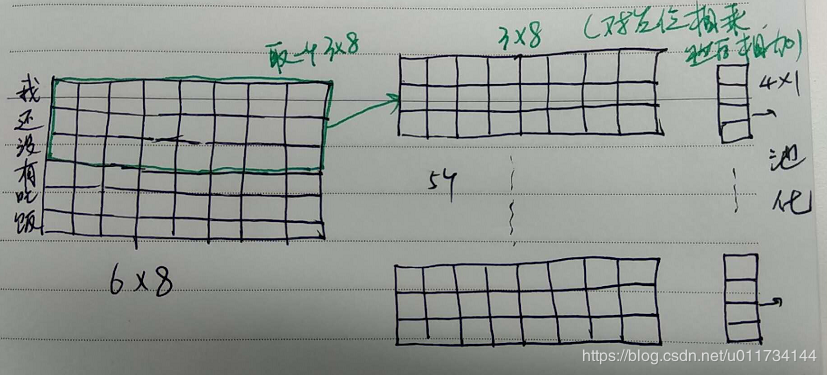

# 18 tensorflow基础知识：tf.reduce_max()


根据张量的某个维度求张量中元素的最大值

tf.reduce_max(input_tensor,axis=None,keepdims=None,name=None,reduction_indices=None,keep_dims=None)


In [20]:
#找出列上的最大值    
import tensorflow as tf
obj = np.asarray([[[1,3,2],[4,5,6]],[[1,3,2],[4,5,6]],[[1,3,2],[4,5,6]]])
max_value = tf.reduce_max(obj,reduction_indices=[0],name='max_of_column')
with tf.Session() as sess:
    max_value = sess.run(max_value)
    print(max_value)

[[1 3 2]
 [4 5 6]]


In [21]:
obj.shape

(3, 2, 3)

In [22]:
max_value.shape

(2, 3)

In [24]:
#找出行上的最大值：
import numpy as np
obj = np.asarray([[[1,3,2],[4,5,6]],[[1,3,2],[4,5,6]],[[1,3,2],[4,5,6]]])
max_value_1 = tf.reduce_max(obj,reduction_indices=[1],name='max_of_raw')
with tf.Session() as sess:
    max_value_1 = sess.run(max_value_1)
    print(obj)
    print('\n')
    print(max_value_1)
#结果可能不太好理解，和我想象的恰好相反，我以为会是（3，2）的结果。实际上第一维按行求，然后（2，3）按列求，于是得到了（3，3）
#在文本处理CNN的最大池化层中，用上了求行的最大值，第三维是卷积核的个数，留下了，第二维消失了。

[[[1 3 2]
  [4 5 6]]

 [[1 3 2]
  [4 5 6]]

 [[1 3 2]
  [4 5 6]]]


[[4 5 6]
 [4 5 6]
 [4 5 6]]


In [18]:
obj.shape

(3, 2, 3)

In [19]:
max_value_1.shape

(3, 3)

# 19 tensorflow知识：tf.layers.dense用法


用于添加一个全连接层


    tf.layers.dense(inputs,units,activation=None,use_bias=True,
    
        kernel_initializer=None,  #卷积核的初始化器

        bias_initializer=tf.zeros_initializer(),  #偏置项的初始化器，默认初始化为0

        name=None,  ##层的名字

        reuse=None)  ##是否重复使用参数
        
        
**部分参数解释：**

    inputs：输入该网络层的数据

    units：输出的维度大小，改变inputs的最后一维

    activation：激活函数，即神经网络的非线性变化
    
    
**示例：**

    dense1 = tf.layers.dense(inputs=pool3, units=1024, activation=tf.nn.relu)
    
    dense2 = tf.layers.dense(inputs=dense1, units=512, activation =tf.nn.relu)

    logits= tf.layers.dense(inputs=dense2, units=10, activation=None)


# 20 tensorflow知识：tf.nn 和tf.layers以及tf.contrib.layers的简单区别



## 1 区别：

tf.nn，tf.layers， tf.contrib.layers模块有很多功能是重复的，尤其是卷积操作，在使用的时候，我们可以根据需要现在不同的模块。但有些时候

可以一起混用。

（1）tf.nn ：提供神经网络相关操作的支持，包括卷积操作（conv）、池化操作（pooling）、归一化、loss、分类操作、embedding、RNN、

     Evaluation。

（2）tf.layers：主要提供的高层的神经网络，主要和卷积相关的，个人感觉是对tf.nn的进一步封装，tf.nn会更底层一些。

（3）tf.contrib：tf.contrib.layers提供够将计算图中的网络层、正则化、摘要操作、是构建计算图的高级操作,又是对tf.layers的进一步封装。

（4）tf.nn是最基础的层，如tf.nn.conv2d, tf.nn.max_pool等，需要编程者自己定义权重。

## 2 各自的方法：

（1）卷积函数我们使用tf.contrib.layers.conv2d()，池化函数使用tf.contrib.layers.max_pool2d()和
 
    tf.contrib.layers.avg_pool2d()，全连接函数使用tf.contrib.layers.fully_connected()。
   
（2）[tf.nn的方法很多](https://blog.csdn.net/jiaoyangwm/article/details/79247371)，激活函数有tf.nn.relu() tf.nn.softmax,池化函数有tf.nn.max_pool,等方法。


In [25]:
#使用relu()激活函数，将大于0的数保持不变，小于0的数置为0
import tensorflow as tf

a = tf.constant([[-2,-4],[4,-2]])
with tf.Session() as sess:
    print(sess.run(tf.nn.relu(a)))

[[0 0]
 [4 0]]


# 21 tensorflow知识：tf.nn.softmax()

[参考资料](https://blog.csdn.net/wgj99991111/article/details/83586508)

Softmax回归，将logistic的预测二分类的概率的问题推广到了n分类的概率的问题。

其公式为：$y_j=\frac{e^{x_j}}{\sum_{k=1}^Ke^{y_k}}$  或者  $p(y=j|x,W)=\frac{exp(w^T_j x)}{\sum_{k=1}^K{exp(w^T_k x)}}$

W是全连接层的参数，我们也称为权值是个K*N的矩阵，这个N和X的N对应，K表示类别数，比如你进行手写数字识别，就是10个分类，那么K就是10。

X是全连接层的输入，也就是特征, 特征X是(N,1)的向量，是由全连接层前面多个卷积、激活和池化层处理后得到的。

Softmax就是把X（N，1）这个向量归一化为（0，1）之间的值，也就是该样本属于各个类的概率，维度是（K，1）。

**语法：**

tf.nn.softmax(logits, axis=None, name=None, dim=None) ,axis默认为-1，即最后一个维度。

In [27]:
# 在最后一个维度上进行softmax
import tensorflow as tf

inputs = tf.constant(5,dtype =tf.float32,shape=(5,3))
with tf.Session() as sess:
    #默认dim=-1,在最后一个维度上进行,实际上每个元素就是（1/3），是把每一行进行计算。
    s = tf.nn.softmax(inputs)
    result = sess.run(s)
    print(result)
# 在CNN文本处理的案例中，就是用的默认维度，全链接层输出是（1，10）的向量，作为softmax层的输入，作用是把元素转化0-1之间的概率值

[[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]]


In [28]:
#在第一个维度上进行
import tensorflow as tf

inputs = tf.constant(5,dtype =tf.float32,shape=(5,3))
with tf.Session() as sess:
    #在第一个维度上进行,实际上每个元素就是（1/5），是把每一行进行计算。
    s = tf.nn.softmax(inputs,dim=0)
    result = sess.run(s)
    print(result)


Instructions for updating:
dim is deprecated, use axis instead
[[0.2 0.2 0.2]
 [0.2 0.2 0.2]
 [0.2 0.2 0.2]
 [0.2 0.2 0.2]
 [0.2 0.2 0.2]]


# 22 tensorflow知识：tf.argmax()

tf.argmax可以认为就是np.argmax。tensorflow使用numpy实现的这个API。tf.argmax就是返回最大的那个数值所在的下标。

tf.argmax(vector, axis)：返回的是vector中的最大值的索引号。

In [30]:
import tensorflow as tf
A = [[1,3,4], [2,4,1]]
 
with tf.Session() as sess:
    #在文本分类的处理中，设置axis=1,因为输入的A是（N，K）的向量，N是batch_size,K为类别，因此返回每行中最大值的下标。
    print(sess.run(tf.argmax(A, 0)))
    print(sess.run(tf.argmax(A, 1)))

[1 1 0]
[2 1]


# 23 tensorflow知识：tf.nn.softmax_cross_entropy_with_logits()

[介绍得贼好](https://blog.csdn.net/yhily2008/article/details/80262321)

**语法**

    tf.nn.softmax_cross_entropy_with_logits(labels=None,logits=None,dim=-1,name=None)
    
（1）这个函数的功能就是计算labels和logits之间的交叉熵（cross entropy，交叉熵（Cross Entropy）是Shannon信息论中一个重要概念，主要用

于度量两个概率分布间的差异性信息。

（2）参数label的含义就是一个分类标签，所不同的是，这个label是分类的概率，比如说[0.2,0.3,0.5]，labels的每一行必须是一个概率分布（即概

率之合加起来为1）。

（3）参数logits，logit的值域范围[-inf,+inf]（即正负无穷区间）。我们可以把logist理解为原生态的、未经缩放的，可视为一种未归一化的“概率

替代物”，如[4, 1, -2]。它可以是其他分类器（如逻辑回归等、SVM等）的输出。

（4）由于logis本身并不是一个概率，所以用Softmax把概率替代物（logits）的值从[-inf, +inf] 映射到[0,1]之间的概率向量。这样一来，经过

Softmax加工的数据可以当做概率分布来用。

（5）经过softmax的加工，就变成“归一化”的概率（设为p1），这个新生成的概率p1，和labels所代表的概率分布（设为p2）一起作为参数，用来计算交

叉熵。


**在文本处理中：**

（1）如果labels的每一行是one-hot表示，也就是只有一个地方为1（或者说100%），其他地方为0（或者说0%），也是概率分布，还可以使用

tf.sparse_softmax_cross_entropy_with_logits()。


 (2) 参数labels,logits必须有相同的形状 [batch_size, num_classes] 和相同的类型(float16, float32, float64)中的一种，否则交叉熵无
 
 法计算。

（3）tf.nn.softmax_cross_entropy_with_logits 函数内部的 logits 不能进行缩放，因为在这个工作会在该函数内部进行（注意函数名称中的 

softmax ，它负责完成原始数据的归一化），如果 logits 进行了缩放，那么反而会影响计算正确性。

（4）tf.nn.softmax_cross_entropy_with_logits（）函数已经过时 (deprecated)，它在TensorFlow未来的版本中将被去除。取而代之的是

tf.nn.softmax_cross_entropy_with_logits_v2（）。


In [32]:
import tensorflow as tf

labels = [[0.2,0.3,0.5],
          [0.1,0.6,0.3]]
logits = [[4,1,-2],
          [0.1,1,3]]

logits_scaled = tf.nn.softmax(logits)
#这里算了两步，一步是上面的这个softmax运算，第二步是把求出的概率分布和labels这个ont_hot向量进行求交叉熵
#结果的维度是（1，2），也就是两个样本的交叉熵损失
result = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=logits)

with tf.Session() as sess:
    print(sess.run(logits_scaled))
    print(sess.run(result))

[[0.95033026 0.04731416 0.00235563]
 [0.04622407 0.11369288 0.84008306]]
[3.9509459 1.6642545]


# 24 tensorflow基础知识：

# tf.train.AdamOptimizer(learning_rate).minimize(loss)

tf.train中有几种常用的优化器：

①tf.train.GradientDescentOptimizer()使用随机梯度下降算法。

②tf.train.MomentumOptimizer()在更新参数时，利用了超参数，参数更新公式是：

 其中，𝛼为学习率，超参数为𝛽，𝜃为参数，𝑔(𝜃𝑖−1 )为损失函数的梯度。
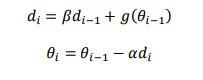

③tf.train.AdamOptimizer()是利用自适应学习率的优化算法，Adam 算法和随机梯度下降算法不同。随机梯度下降算法保持单一的学习率更新所有的参

数，而 Adam 算法通过计算梯度的一阶矩估计和二阶矩估计而为不同的参数设计独立的自适应性学习率。


# 25 tensorflow基础知识：tf.equal()，tf.cast()

**tf.equal(x, y, name=None)**

判断x, y 是不是相等，逐个元素进行判断，如果相等就是True，不相等，就是False。由于是逐个元素判断，所以x，y 的维度要一致。

**tf.cast(x,dtype,name)**

此函数是类型转换函数,如果x是bool类型，指定dtype=float32,就可以转化为该类型。


In [1]:
# 将布尔类型转化为浮点型，便于计算准确率
import tensorflow as tf
x = tf.Variable([True,False,True,True,False])
y = tf.cast(x,dtype=tf.float32)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(y)
    print(result)
    print(sess.run(tf.reduce_mean(result)))

[1. 0. 1. 1. 0.]
0.6


# 26 python知识：[:, np.newaxis]

np.newaxis用于在行或列上增加维度，[:, np.newaxis]是在列上增加维度，[np.newaxis,:]是在行上增加维度

In [2]:
import numpy as np
a=np.array([1,2,3,4,5])
#原来是(5,)的数组，在列上增加维度变成了（5，1）的二维数组，或者说进行了装置。
b=a[:,np.newaxis]
print("a.shape is:",a.shape)
print("b.shape is: ",b.shape)
print(a)
print (b)

a.shape is: (5,)
b.shape is:  (5, 1)
[1 2 3 4 5]
[[1]
 [2]
 [3]
 [4]
 [5]]


In [3]:
a=np.array([1,2,3,4,5])
#原来是(5,)的数组，在行上增加维度变成了（1，5）的二维数组
b_1=a[np.newaxis,:]
print("a.shape is:",a.shape)
print("b_1.shape is: ",b_1.shape)
print(a)
print (b_1)

a.shape is: (5,)
b_1.shape is:  (1, 5)
[1 2 3 4 5]
[[1 2 3 4 5]]


# 27 tensorflow知识：保存模型tf.train.Saver()


[参考资料](https://blog.csdn.net/index20001/article/details/74322198)


首先，保存和恢复都需要实例化一个 tf.train.Saver。

    saver = tf.train.Saver()

然后，训练循环中，定期调用 saver.save() 方法，向文件夹中写入包含当前模型中所有可训练变量的 checkpoint 文件。

    saver.save(sess, save_path, global_step=step)

之后，就可以使用 saver.restore() 方法，重载模型的参数，继续训练或用于测试数据。

    saver.restore(sess, save_path)


其中，save.save主要就是三个参数，save.save(self,sess,save_path,global_step=None,latest_filename=None,其他参数)。第一个参数

sess,这个就不用说了。第二个参数设定保存的路径和名字，第三个参数将训练的次数作为后缀加入到模型名字中。

# 28 python知识：{}.format()

这个函数是用于规范打印的输出，通过在{}进行设置可以产生很多特殊效果。

'<' 强制字段在可用空间内左对齐（这是大多数对象的默认值）。

'>' 强制字段在可用空间内右对齐（这是数字的默认值）

In [6]:
loss_test=0.15651663
acc_test=0.9484462

# {0:>5.2}的意思是：0代表传入第一个值：loss_test,5代表为这个值留出5个占位符，2表示保留2为小数，>表示值进行右对齐。
msg = 'Test Loss: {0:>5.2}, Test Acc: {1:>7.2%}'
print(msg.format(loss_test, acc_test))

Test Loss:  0.16, Test Acc:  94.84%


In [7]:
msg = 'Test Loss: {0:>10.4}, Test Acc: {1:>10.4%}'
print(msg.format(loss_test, acc_test))

Test Loss:     0.1565, Test Acc:   94.8446%


# 29 sklearn知识：metrics.classification_report()


## 1 metrics.classification_report()


sklearn.metrics.classification_report函数用于显示主要分类指标的文本报告，在报告中显示每个类的精确度，召回率，F1值等信息。 

主要参数: 

y_true：1维数组，目标值。 

y_pred：1维数组，分类器返回的估计值。 

target_names：字符串列表，与标签匹配的可选显示名称（相同顺序）。

F1_score的值用如下公式计算：

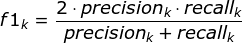


## 2 metrics.confusion_matrix()

混淆矩阵函数函数：sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)，参与与上面的类似。

abels：是所给出的类别，通过这个可对类别进行选择，sample_weight : 样本权重。

In [2]:
from sklearn.metrics import classification_report
# 有三个类别，分别用0，1，2表是
# 举例：类别0的presion=0.5=(1/2), recall=1=(1/1)，F1_score=2*(presion*recall)/(presion+recall)=0.67
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']

print(classification_report(y_true,y_pred,target_names=target_names))


              precision    recall  f1-score   support

     class 0       0.50      1.00      0.67         1
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.67      0.80         3

   micro avg       0.60      0.60      0.60         5
   macro avg       0.50      0.56      0.49         5
weighted avg       0.70      0.60      0.61         5



In [4]:
from sklearn.metrics import confusion_matrix

#这个计算混淆矩阵的例子是沿着上面的，可以看到target_names和labels的区别，
#labels必须用类别的本身的值，而不能用名词，不能用‘class 0’这样。
print(confusion_matrix(y_true,y_pred,labels=[0,1,2]))

[[1 0 0]
 [1 0 0]
 [0 1 2]]


# 30 python知识：from __ future __ import  * 

[参考资料：廖雪峰](https://www.liaoxuefeng.com/wiki/001374738125095c955c1e6d8bb493182103fac9270762a000/001386820023084e5263fe54fde4e4e8616597058cc4ba1000)

## 1 

如果电脑中python的版本是2.7的，那么在当前版本运行正常的代码，到3.x版本运行就可能不正常了。

直接把代码升级到3.x是比较冒进的，因为有大量的改动需要测试。相反，可以在2.7版本中先在一部分代码中测试一些3.x的特性，如果没有问题，再移植

到3.x不迟。

Python提供了__future__模块，把下一个新版本的特性导入到当前版本，于是我们就可以在当前版本中测试一些新版本的特性。

引入这个模块后，把代码仍然在2.7中运行测试，如果没有问题，那就不用改了，因为在3.x中也可以运行。

比如在2.7版本中可以用3.x的print()方式来进行打印，那么如果代码是用3.x写的，被别人用2.7版本运行时也不会报错。

from __future__ import print_function 

print("Hello World")


## 2

tensorlow主要会导入三个东西：

    from __future__ import absolute_import

    from __future__ import division

    from __future__ import print_function

导入division是为了使用3.x中的除法特性，即用/来除会得到浮点型（3/2=1.333），用//是地板除（3//2=1），而2.7中，3.0/2=1.333，3/2=1

在加入了from __future__ import absolute_import 之后，那么在程序的编写过程中使用类似from package.submodule import b 只能导入系统

环境路径里面的包，导入不了你写的应用程序的子包，如果导入你写的应用程序的子包必须使用from ..submodule import b。

例如：

from .celery import Celery

是导入当前路径下celery的Celery

from celery import Celery

是导入第三方的全局的celery模块下的Celery

# 31 python知识：dir()函数 和 import sys


## 1 dir()

内置的函数 dir() 可以找到模块内定义的所有名称。以一个字符串列表的形式返回.


## 2 import sys()

sys模块包含了与Python解释器和它的环境有关的函数。

**(1) sys.path 包含输入模块的目录名列表。**

获取指定模块搜索路径的字符串集合，可以将写好的模块放在得到的某个路径下，就可以在程序中import时正确找到。

也可以自定义添加模块路径。sys.path.append(“自定义模块路径”)。


**(2) sys.getdefaultencoding() / sys.setdefaultencoding() / sys.getfilesystemencoding()**

sys.getdefaultencoding()

获取系统当前编码，一般默认为ascii。


sys.setdefaultencoding()

设置系统默认编码，执行dir（sys）时不会看到这个方法，在解释器中执行不通过，可以先执行reload(sys)，在执行 

setdefaultencoding(‘utf8’)，此时将系统默认编码设置为utf8。


sys.getfilesystemencoding()

获取文件系统使用编码方式，Windows下返回’mbcs’，mac下返回’utf-8’


In [9]:
import sys
dir(sys)[:5] #太长了，我设置为只显示前5个。

['__displayhook__',
 '__doc__',
 '__excepthook__',
 '__interactivehook__',
 '__loader__']

In [10]:
sys.path # 可以理解为python的执行路径吧，可以把模块放在这些路径下，就会被正确的import

['/home/dyy/anaconda3/envs/tf/lib/python36.zip',
 '/home/dyy/anaconda3/envs/tf/lib/python3.6',
 '/home/dyy/anaconda3/envs/tf/lib/python3.6/lib-dynload',
 '',
 '/home/dyy/anaconda3/envs/tf/lib/python3.6/site-packages',
 '/home/dyy/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/extensions',
 '/home/dyy/.ipython']

# 32 tensorflow知识：LSTM模型的定义

[参考资料]:(https://blog.csdn.net/qq_35203425/article/details/79572514)

https://blog.csdn.net/liushao123456789/article/details/78991581

https://blog.csdn.net/qq_35203425/article/details/79572514

**定义**

    # lstmCell = tf.contrib.rnn.BasicLSTMCell(num_units,state_is_tuple=True)
    # 上面这种定义方法已经被官方所舍弃，用下面这个方法定义LSTM层。
    
    lstmCell = tf.nn.rnn_cell.LSTMCell（num_units,state_is_tuple=True）

    lstmCell = tf.nn.rnn_cell.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)

    output, last_state = tf.nn.dynamic_rnn(lstmCell, embedding_inputs, dtype=tf.float32)
    
    last = value[:, -1, :]

num_units是每个LSTM隐层中神经元的个数，假设为128，output_keep_prob是输出到下一层（双层LSTM的下一个LSTM层或全连接层，而不是按时间序列的右边的LSTM。）的保留比例。

假设emdedding_inputs为（128，600，64）,即取128个样本作为一个batch,每个文本600个字，然后词嵌入维度是64，那么那么第三步的value的维度

是（128，600，128），从时间序列上看时间是从t0-t599,然后我们取最后一个输出，于是last就是（128，128）,也就是（batch_size,num_units).

但其实last_state是一个元组，元组的第二个元素就是我们需要的最后一个输出，输入last_state.h，就可以得到。而且这比我们手动用[:,-1,:]取用

好处，因为如果最后一个输出是全是0，那么last_state会取找最后一个非0的输出向量，而手动的方法就是取最后一个输出，当然我并不知道取非0向量的

意义。

[参考资料2](https://blog.csdn.net/junjun150013652/article/details/81331448)

下面这个例子要注意两点，

一是我们设置了seq_length_batch,这玩意是干嘛的呢，sequence_length，这个参数用来指定每个example的长度，比如下面的例子里我们令sequence_length为[2,1,2,2]，表示第一个example有效长度为2，第二个example有效长度为1，当我们传入这个参数的时候，对于第二个batch，TensorFlow对于1以后的padding就不计算了，其states将用第1步的输出作为第2步的输出，而outputs中超过第1步的结果将会被置零(也就是不计算了，直接搞成0)。

二是最后的输出其实不用我们自己提取，用states.h就可以取到，而且还会自动去掉全为0的向量。states是由(c,h)组成的tuple，大小均为[batch,num_Units]。所以如果想用dynamic_rnn得到输出后，只需要最后一次的状态输出，直接调用states.h即可，

In [1]:
import tensorflow as tf
import numpy as np
 
n_steps = 2
n_inputs = 3
n_neurons = 5

#假如取batch取4，那么维度是（4，2，3）
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.LSTMCell(num_units=n_neurons)
 
seq_length = tf.placeholder(tf.int32, [None])

#outputs的维度是（4，2，5）,states是一个元组，包含了最后一步输出的结果，这里一共有两步。
#states.c得到横向上的最后输出，维度（4，5），states.s得到纵向上的最后输出，维度（4，5）
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    sequence_length=seq_length)
 
init = tf.global_variables_initializer()
 
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])
 
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})
    print("outputs_val.shape:", outputs_val.shape)
    print("outputs_val:", outputs_val,'\n\n',"states_val:", states_val)
    
#可以看到，尽管outputs_val的第二行里面第二行的元素全是0，但是也就是第二个样本输入后的纵向上的最后输出为0，
#但是states返回的值取是第一步的输出，因为第一步的输出是非0向量。    

outputs_val.shape: (4, 2, 5)
outputs_val: [[[ 0.01405989  0.22927189  0.15902328 -0.08969484 -0.09322944]
  [-0.1653217   0.04236752  0.7704647   0.01859272  0.37517884]]

 [[-0.07197583  0.14209722  0.72136813  0.01916011  0.12384444]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.11382499  0.05315086  0.7596531   0.02706561  0.24403186]
  [-0.270425    0.11810695  0.85045844  0.07288362  0.52715784]]

 [[-0.11301615 -0.0884975   0.73026264  0.22759925  0.12081625]
  [-0.3672786  -0.11830397  0.77582926  0.19247857  0.30055988]]] 

 states_val: LSTMStateTuple(c=array([[-0.61693966,  1.2857618 ,  1.0218372 ,  0.41751704,  0.659262  ],
       [-0.14642544,  0.9735087 ,  0.9325591 ,  0.10612191,  0.3540039 ],
       [-0.746107  ,  1.4030352 ,  1.2745168 ,  0.9767467 ,  1.1181608 ],
       [-1.1204647 , -0.40228617,  1.3517888 ,  1.0110289 ,  0.4961908 ]],
      dtype=float32), h=array([[-0.1653217 ,  0.04236752,  0.7704647 ,  0.01859272,  0.37517884],
       [-0.

In [ ]:
下面的代码没有给seq_length这个参数传入值，结果就是尽管第二个样本的step1全是0，但是输入到第二步隐含层中计算的并不是这个0向量，而是
第一步的[3,4,5](我其实也不太确定是不是)，因此第二步的输出不是0向量，用states.h取的和上面例子的值不一样。

In [2]:
import tensorflow as tf
import numpy as np
 
n_steps = 2
n_inputs = 3
n_neurons = 5
 
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.nn.rnn_cell.LSTMCell(num_units=n_neurons)
 
#seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32,
                                    )
 
init = tf.global_variables_initializer()
 
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
#seq_length_batch = np.array([2, 1, 2, 2])
 
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch})
    print("outputs_val.shape:", outputs_val.shape)
    print("outputs_val:", outputs_val,'\n\n',"states_val:", states_val)

outputs_val.shape: (4, 2, 5)
outputs_val: [[[-0.07652018 -0.1754897   0.03950775  0.06690412 -0.2880308 ]
  [-0.46060288 -0.76172197  0.00229007  0.2888354  -0.52223766]]

 [[-0.18459402 -0.31983688 -0.02221629  0.17990507 -0.48375842]
  [-0.08696945 -0.28600657 -0.07253981  0.08921377 -0.28751758]]

 [[-0.19967282 -0.420777   -0.00454657  0.15254065 -0.5803354 ]
  [-0.49848917 -0.7442827  -0.03323046  0.31661826 -0.44898129]]

 [[-0.36956334  0.4281445  -0.09419996  0.01573689  0.6224246 ]
  [-0.40285933  0.09546418 -0.2708034   0.25791976  0.3631132 ]]] 

 states_val: LSTMStateTuple(c=array([[-0.6580056 , -1.3743713 ,  0.02160194,  0.4007235 , -0.87785363],
       [-0.16101854, -0.60234034, -0.15721771,  0.1728837 , -0.6249483 ],
       [-0.7878685 , -1.5316721 , -0.19907846,  0.54584235, -0.8311754 ],
       [-0.798735  ,  0.13218063, -1.1324455 ,  0.9230149 ,  1.2142006 ]],
      dtype=float32), h=array([[-0.46060288, -0.76172197,  0.00229007,  0.2888354 , -0.52223766],
       [-0.

In [3]:
states_val.h

array([[-0.46060288, -0.76172197,  0.00229007,  0.2888354 , -0.52223766],
       [-0.08696945, -0.28600657, -0.07253981,  0.08921377, -0.28751758],
       [-0.49848917, -0.7442827 , -0.03323046,  0.31661826, -0.44898129],
       [-0.40285933,  0.09546418, -0.2708034 ,  0.25791976,  0.3631132 ]],
      dtype=float32)

#  tf.nn.rnn_cell.DropoutWrapper 或  tf.contrib.rnn.DropoutWrapper    


在rnn中使用dropout的方法和cnn不同，在rnn中进行dropout时，对于rnn的部分不进行dropout，也就是说从t-1时候的状态传递到t时刻进行计算时，

这个中间不进行memory的dropout；仅在同一个t时刻中，多层cell之间传递信息的时候进行dropout，如下图所示

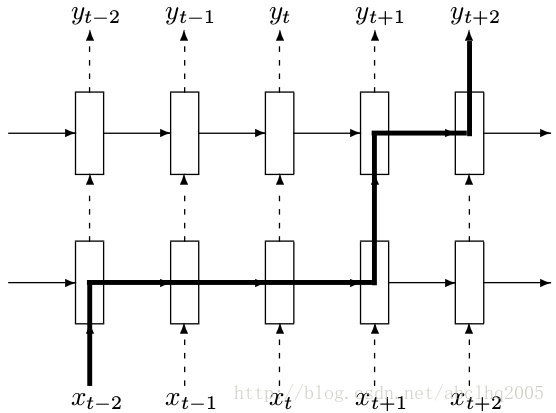

Dropout只能是层与层之间（输入层与LSTM1层、LSTM1层与LSTM2层）的Dropout；同一个层里面，T时刻与T+1时刻是不会Dropout的。
